In [1]:
from src import *
from data.scanner.CAVA_V1 import datasets_cava_v1
import ffmpegio
gpu = 0

In [2]:
def load_experiment(results_dir, model):
    param = torch.load(os.path.join(results_dir, "param.pth"))
    spec = importlib.util.spec_from_file_location("module.name", os.path.abspath(os.path.join(results_dir, os.path.basename(param.experiment.script_file_path))))
    experiment_script = importlib.util.module_from_spec(spec)
    sys.modules["module.name"] = experiment_script
    spec.loader.exec_module(experiment_script)
    exp = experiment_script.load_experiment(results_dir, model, gpu=gpu)
    return exp

In [12]:
dataset_nr = 10
results_dir = "results/cava_v1/10/KFMLP/validation/900/hdr/s_t 1.0 sx 15.0 out_scale 1000.0 eps 10000.0 sigma 10.0 lambda 0.1"
model = "training/ser_highscore.pth"
exp = load_experiment(results_dir, model)
exp.model.compute_weighted_smaps(exp.dataset.smaps.squeeze().type(dtype))

In [13]:
def render_mp4(imgs, export_dir, frame_times):
    create_dir(export_dir)

    imgs_rgb = imgs.copy()
    img_max_val = datasets_cava_v1[dataset_nr]["brightness"]

    imgs_rgb /= img_max_val
    imgs_rgb[imgs_rgb > 1.] = 1. # clip maximum
    imgs_rgb[imgs_rgb < 0] = 0. # clip minimum (should not be necessary for absolute valued images)
    imgs_rgb *= 255
    imgs_rgb = np.uint8(imgs_rgb)

    imgs_rgb = np.expand_dims(imgs_rgb, axis=3)
    imgs_rgb = imgs_rgb.repeat(3, axis=3)

    raw_video_file = os.path.join(export_dir, '30fps_cfr.mp4')

    ffmpegio.video.write(raw_video_file, 30, imgs_rgb, overwrite=True)

    # write timecode file

    timecode = """# timecode format v2

    """
    for i, t_k in enumerate(frame_times):
        if i >= len(imgs): break
        timecode += "{}\n".format(t_k * 1000)

    timecodes_file = os.path.join(export_dir, 'timecodes.txt')
    with open(timecodes_file, 'w') as f:
        f.write(timecode)

    timecoded_vfr_file = os.path.join(export_dir, 'timecoded_vfr.mp4')
    timecoded_cfr_file = os.path.join(export_dir, 'timecoded_cfr.mp4')


    os.system("mp4fpsmod -o \"{}\" -t \"{}\" \"{}\"".format(timecoded_vfr_file, timecodes_file, raw_video_file))
    os.system("ffmpeg -y -i \"{}\" \"{}\"".format(timecoded_vfr_file, timecoded_cfr_file))



if dataset_nr == 10 or dataset_nr == 15:
    imgs = np.stack([np.rot90(exp.model.evaluate_npy(copySampleToGPU(sample))[26:-26,65:-65]) for sample in exp.dataset])
else:
    imgs = np.stack([np.rot90(exp.model.evaluate_npy(copySampleToGPU(sample))[47:-47,120:-120]) for sample in exp.dataset])

export_dir = "supplements/lowres_highsnr/KFMLP/900/"
render_mp4(imgs, export_dir, exp.param.data.frame_times)


Input #0, rawvideo, from 'pipe:':
  Duration: N/A, start: 0.000000, bitrate: 12928 kb/s
    Stream #0:0: Video: rawvideo (RGB[24] / 0x18424752), rgb24, 134x134, 12928 kb/s, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> h264 (libx264))
[swscaler @ 0x55c20ccd47e0] Warning: data is not aligned! This can lead to a speed loss
[libx264 @ 0x55c20ccb2900] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55c20ccb2900] profile High 4:4:4 Predictive, level 1.1, 4:4:4 8-bit
[libx264 @ 0x55c20ccb2900] 264 - core 152 r2854 e9a5903 - H.264/MPEG-4 AVC codec - Copyleft 2003-2017 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x1:0x111 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=4 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bf

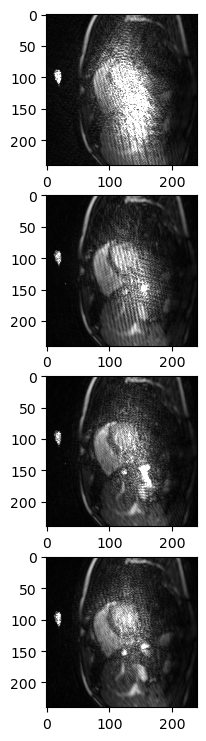

In [5]:

images = [exp.model.evaluate_npy(copySampleToGPU(exp.dataset[k])) for k in [105, 115, 125, 135]]
if dataset_nr == 10 or dataset_nr == 15: # low-res
    images = [np.rot90(img[26:-26,65:-65]) for img in images]
else: # high-res
    images = [np.rot90(img[47:-47,120:-120]) for img in images]

import glob, tikzplotlib

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9, 9))
brightness = datasets_cava_v1[20]["brightness"]
for i, img in enumerate(images):
    axes[i].imshow(img, cmap="gray", vmax=brightness, vmin=0)

create_dir(os.path.join(results_dir, "figures"))
tex_file_name = os.path.join(results_dir, "figures/kfmlp.tex")
for file in glob.glob(os.path.splitext(tex_file_name)[0] + "-*"):
    os.remove(file)
tikzplotlib.save(tex_file_name, standalone=False)